## Boundary conditions

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import glob
from math import isclose
import scipy.ndimage as ndimage
import matplotlib
import pickle
import xarray as xr

%matplotlib inline

#### Parameters

In [44]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

# Boundary coordinates:
N_coordinates = ((2168, 2178, 201, 798))
E_coordinates = ((1481, 2178, 778, 798))
S_coordinates = ((1482, 1492, 181, 798))

# Colours:
land_color = '#a9a7a2'

# Rimwidth:
rimwidth_north = 10 # western Canada Basin
rimwidth_east  = 20 # northern Canada Basin
rimwidth_south = 10 # Baffin Bay

In [18]:
stn1i = 567+imin; stn1j = 407+jmin;

#### Load files

In [19]:
IC  = '/ocean/brogalla/GEOTRACES/data/Mn_ini_20210810.nc'
ICd = nc.Dataset(IC)
IC_dMn = np.array(ICd.variables['dMn'])[0,:,:,:]
IC_oMn = np.array(ICd.variables['oMn'])[0,:,:,:]

In [20]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = np.array(mesh.variables['nav_lev'])
mesh_hdept   = np.array(mesh.variables['hdept'][0])

#### Functions

In [21]:
def flatten_input(var, order):
    b = var[0,:,:].flatten(order=order)
    for i in range(1,len(var)):
        a = var[i,:,:].flatten(order=order)
        b = np.vstack((b,a))
    return b

In [22]:
def create_boundary(rimwidth, boundary_dMn, boundary_oMn, order):
    
    dMn_O = flatten_input(boundary_dMn, order)
    oMn_O = flatten_input(boundary_oMn, order)
    
    dMn_OBC = np.reshape(dMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))
    oMn_OBC = np.reshape(oMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))

    return dMn_OBC, oMn_OBC

In [23]:
def save_BC_file(name, dMn_BC, oMn_BC):
    # Setup the new NetCDF file:
    ncd = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/{name}', 'w', zlib=True)
    ncd.createDimension('x', np.max(dMn_BC.shape))
    ncd.createDimension('y',1)
    ncd.createDimension('z',50)
    ncd.createDimension('t',None)
    
    dMn = ncd.createVariable('dMn', 'float64', ('t','z','y','x'))
    dMn.units = 'dissolved Mn'
    dMn.long_name = 'dMn'
    dMn[:] = dMn_BC

    oMn = ncd.createVariable('oMn', 'float64', ('t','z','y','x'))
    oMn.units = 'oxidised Mn'
    oMn.long_name = 'oMn'
    oMn[:] = oMn_BC
    
    ncd.close()
    return

In [24]:
def plot_variable(variable, label='', depth_level=0, v=(0,10)):

    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

    x, y   = proj1(mesh_lon, mesh_lat) 
    CB     = proj1.pcolormesh(x, y, variable[depth_level,:,:]*1e9, vmin=v[0], vmax=v[1])
    
    # At stn 1 in Canada Basin:
    proj1.scatter(x[stn1i,stn1j],y[stn1i,stn1j], c='r', s=20, zorder=3)
    
    cbaxes = fig.add_axes([0.2, 0.22, 0.02, 0.2]) 
    CBar1  = plt.colorbar(CB, ax=ax1, cax=cbaxes, orientation='vertical')
    CBar1.ax.tick_params(labelsize=5) 
    ax1.set_title(label, fontsize=6)

    return

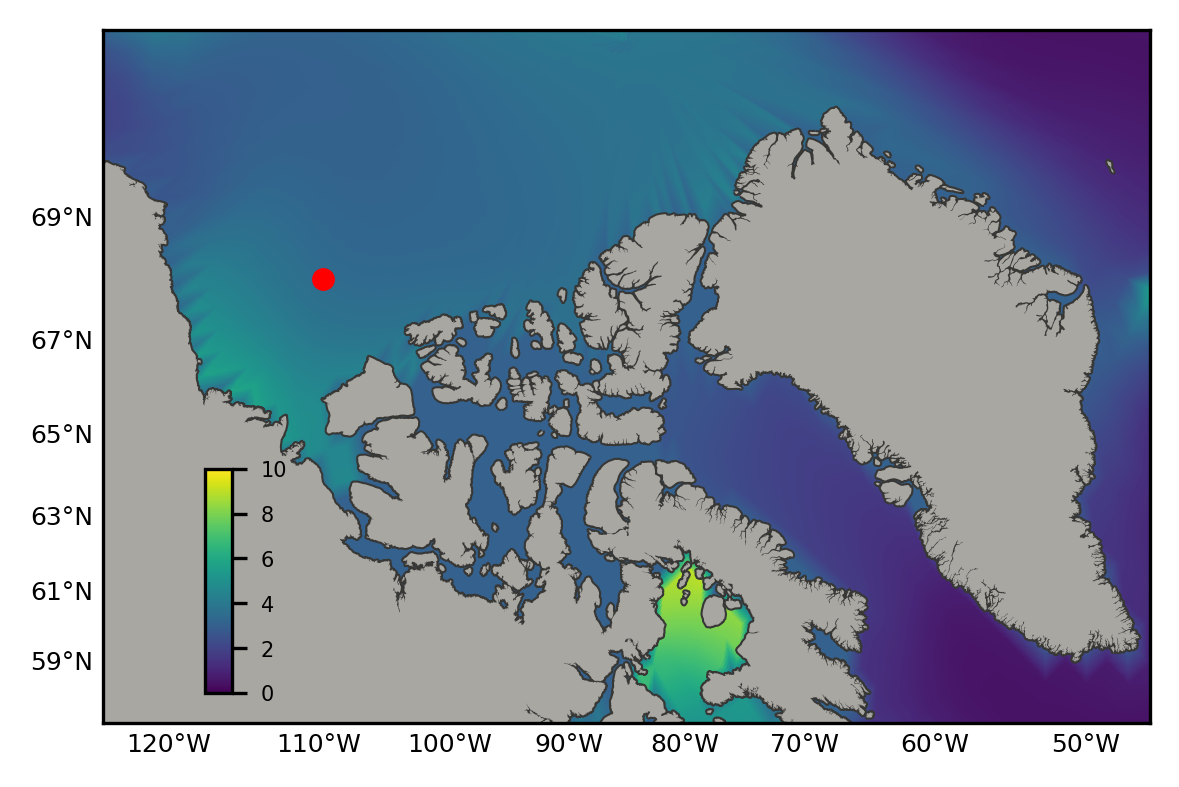

In [10]:
plot_variable(IC_dMn)

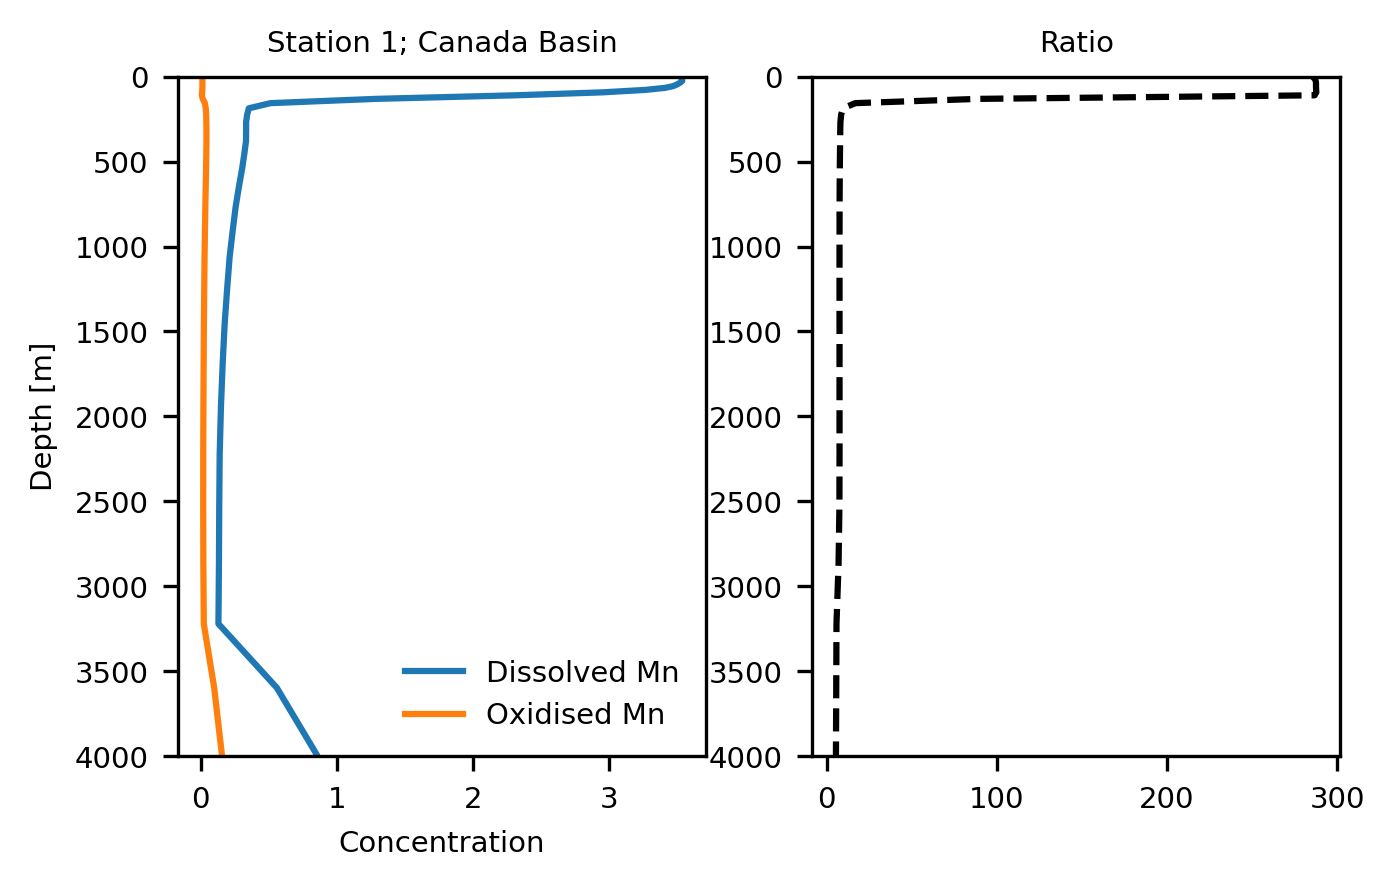

In [34]:
fig, ax = plt.subplots(1,2, figsize=(5,3),dpi=300)
ax[0].invert_yaxis()
ax[0].set_xlabel('Concentration', fontsize=7)
ax[0].set_ylabel('Depth [m]', fontsize=7)
ax[0].plot(IC_dMn[:,stn1i,stn1j]*1e9, mesh_depth, label='Dissolved Mn')
ax[0].plot(IC_oMn[:,stn1i,stn1j]*1e9, mesh_depth, label='Oxidised Mn')
ax[0].legend(frameon=False, fontsize=7)
ax[0].set_title('Station 1; Canada Basin', fontsize=7)
ax[0].tick_params(axis='both', labelsize=7)
ax[0].set_ylim(4000,0)

ax[1].invert_yaxis()
ax[1].set_title('Ratio', fontsize=7)
ax[1].tick_params(axis='both', labelsize=7)
ax[1].set_ylim(4000,0)
ax[1].plot(np.divide(IC_dMn[:,stn1i,stn1j], IC_oMn[:,stn1i,stn1j]), mesh_depth, '--k')

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


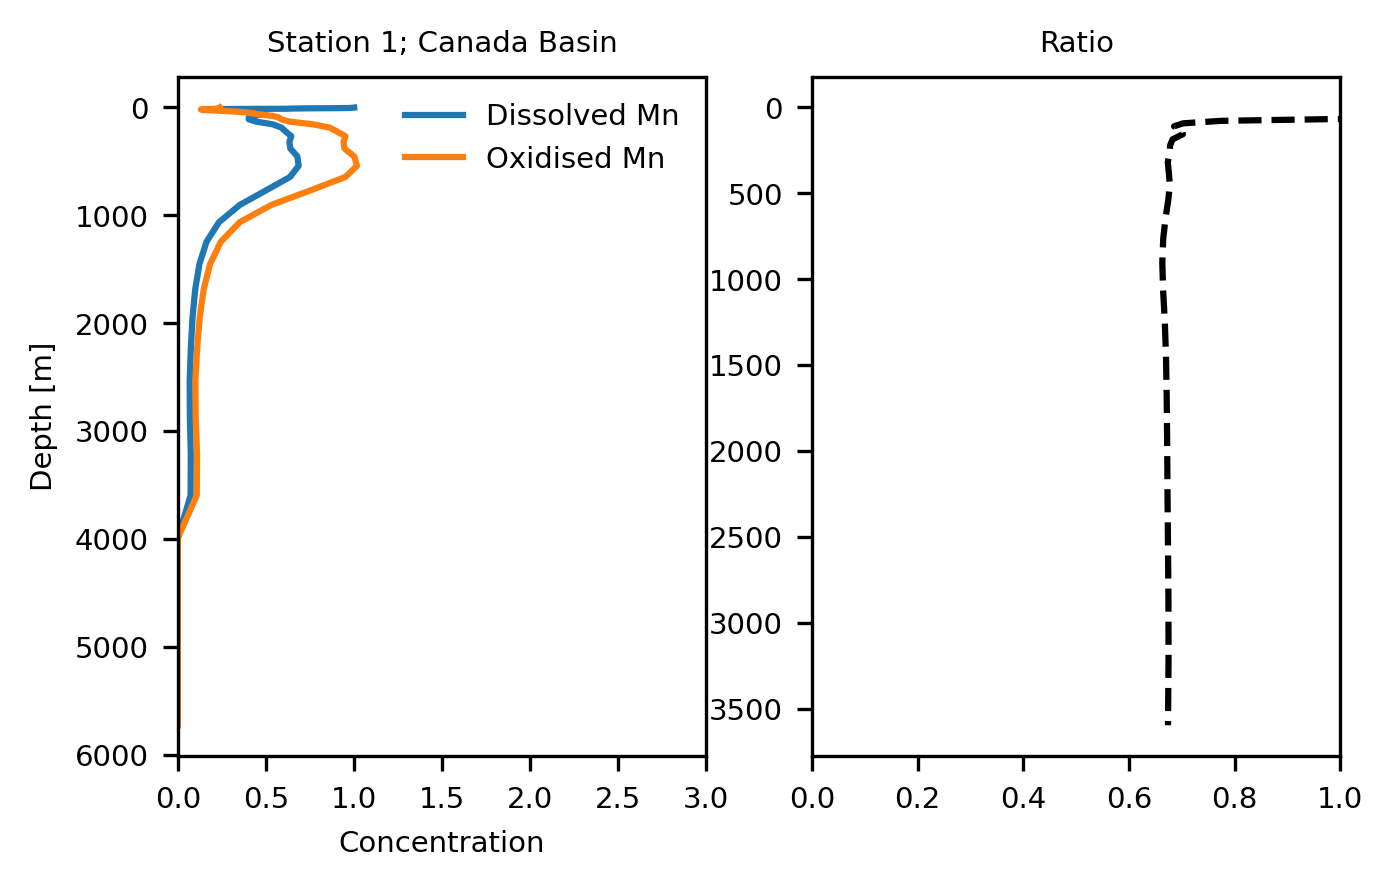

In [35]:
month=5

fig, ax = plt.subplots(1,2, figsize=(5,3),dpi=300)
ax[0].invert_yaxis()
ax[0].set_xlabel('Concentration', fontsize=7)
ax[0].set_ylabel('Depth [m]', fontsize=7)
ax[0].plot(dMn[month,:,stn1i-imin,stn1j-jmin]*1e9, mesh_depth, label='Dissolved Mn')
ax[0].plot(oMn[month,:,stn1i-imin,stn1j-jmin]*1e9, mesh_depth, label='Oxidised Mn')
ax[0].legend(frameon=False, fontsize=7)
ax[0].set_title('Station 1; Canada Basin', fontsize=7)
ax[0].tick_params(axis='both', labelsize=7)
ax[0].set_xlim(0,3)

ax[1].invert_yaxis()
ax[1].set_title('Ratio', fontsize=7)
ax[1].tick_params(axis='both', labelsize=7)
ax[1].set_xlim(0,1)
ax[1].plot(np.divide(dMn[month,:,stn1i-imin,stn1j-jmin], oMn[month,:,stn1i-imin,stn1j-jmin]), mesh_depth, '--k')

In [62]:
# First create global model based boundary condition
dMn_north_IC = IC_dMn[:,N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]]
oMn_north_IC = IC_oMn[:,N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]]

dMn_east_IC  = IC_dMn[:,E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]]
oMn_east_IC  = IC_oMn[:,E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]]

dMn_south_IC = IC_dMn[:,S_coordinates[0]:S_coordinates[1],S_coordinates[2]:S_coordinates[3]]
oMn_south_IC = IC_oMn[:,S_coordinates[0]:S_coordinates[1],S_coordinates[2]:S_coordinates[3]]

dMn_north_BC_IC, oMn_north_BC_IC = create_boundary(rimwidth_north, dMn_north_IC, oMn_north_IC, 'C')
dMn_east_BC_IC , oMn_east_BC_IC  = create_boundary(rimwidth_east , dMn_east_IC , oMn_east_IC , 'F')
dMn_south_BC_IC, oMn_south_BC_IC = create_boundary(rimwidth_south, dMn_south_IC, oMn_south_IC, 'C')

# save_BC_file('Mn_North_OBC_20220419.nc', dMn_north_BC_IC, oMn_north_BC_IC)
# save_BC_file('Mn_East_OBC_20220419.nc' , dMn_east_BC_IC,  oMn_east_BC_IC)
# save_BC_file('Mn_South_OBC_20220419.nc', dMn_south_BC_IC, oMn_south_BC_IC)

In [168]:
# then run for 4 years and use grid cells within domain for the boundary condition.
month = 5

# Load spin up run:
Mn_run = nc.Dataset('/data/brogalla/run_storage/Mn-IC-202204/ANHA12_IC-spin-up3_20220419/ANHA12_EXH006_2002_monthly.nc')
dMn = np.array(Mn_run.variables['dissolmn'])[:,0,:,:,:]
oMn = np.array(Mn_run.variables['oxidismn'])[:,0,:,:,:]
# Mask values on land
dMn_ma = np.ma.masked_where(mesh_bathy[:,imin:imax,jmin:jmax] < 0.1, dMn[month,:,:,:])
oMn_ma = np.ma.masked_where(mesh_bathy[:,imin:imax,jmin:jmax] < 0.1, oMn[month,:,:,:])

# ---------- Estimate boundary conditions based on rimwidth grid cells inside the boundary -------------
# ---- North ----
dMn_north_ma = dMn_ma[:,N_coordinates[0]-imin-rimwidth_north:N_coordinates[1]-imin-rimwidth_north,N_coordinates[2]-jmin:N_coordinates[3]-jmin]
oMn_north_ma = oMn_ma[:,N_coordinates[0]-imin-rimwidth_north:N_coordinates[1]-imin-rimwidth_north,N_coordinates[2]-jmin:N_coordinates[3]-jmin]
# Fill area of overlap with eastern boundary with average of masked array
dMn_north_ma[:,:,-20:] = np.ma.average(dMn_north_ma[:,:,-20:])
oMn_north_ma[:,:,-20:] = np.ma.average(dMn_north_ma[:,:,-20:])

# ---- East ----
dMn_east_ma  = dMn_ma[:,E_coordinates[0]-imin:E_coordinates[1]-imin,E_coordinates[2]-jmin-rimwidth_east:E_coordinates[3]-jmin-rimwidth_east]
oMn_east_ma  = oMn_ma[:,E_coordinates[0]-imin:E_coordinates[1]-imin,E_coordinates[2]-jmin-rimwidth_east:E_coordinates[3]-jmin-rimwidth_east]
# Fill area of overlap with northern boundary with average of masked array
dMn_east_ma[:,-10:,:] = np.ma.average(dMn_east_ma[:,0:-10,:])
oMn_east_ma[:,-10:,:] = np.ma.average(dMn_east_ma[:,0:-10,:])

# ---- South ----
dMn_south_ma = dMn_ma[:,S_coordinates[0]-imin+rimwidth_south:S_coordinates[1]-imin+rimwidth_south,S_coordinates[2]-jmin:S_coordinates[3]-jmin]
oMn_south_ma = oMn_ma[:,S_coordinates[0]-imin+rimwidth_south:S_coordinates[1]-imin+rimwidth_south,S_coordinates[2]-jmin:S_coordinates[3]-jmin]

for z in range(0,50):
    # Fill land with average values in slice
    dMn_north_ma[z,:,:].filled(fill_value=np.ma.average(dMn_north_ma[z,:,:]))
    oMn_north_ma[z,:,:].filled(fill_value=np.ma.average(oMn_north_ma[z,:,:]))
    dMn_east_ma[z,:,:].filled(fill_value=np.ma.average(dMn_east_ma[z,:,:]))
    oMn_east_ma[z,:,:].filled(fill_value=np.ma.average(oMn_east_ma[z,:,:]))
    dMn_south_ma[z,:,:].filled(fill_value=np.ma.average(dMn_south_ma[z,:,:]))
    oMn_south_ma[z,:,:].filled(fill_value=np.ma.average(oMn_south_ma[z,:,:]))
    
    # Mackenzie model forcing copied over, so fill with average of masked array
    dMn_north_ma[z,:,0:300] = np.ma.average(dMn_north_ma[z,:,300:])
    oMn_north_ma[z,:,0:300] = np.ma.average(oMn_north_ma[z,:,300:])
    
    # Inner Nares Strait copied over, so fill with average of masked array
    dMn_east_ma[z,0:170,:] = np.ma.average(dMn_east_ma[z,170:,:])
    oMn_east_ma[z,0:170,:] = np.ma.average(oMn_east_ma[z,170:,:])
    
dMn_north = np.array(dMn_north_ma); oMn_north = np.array(oMn_north_ma);
dMn_east  = np.array(dMn_east_ma);  oMn_east  = np.array(oMn_east_ma);
dMn_south = np.array(dMn_south_ma); oMn_south = np.array(oMn_south_ma);

# Replace zero values with average values:
dMn_north[dMn_north == 0] = np.ma.average(dMn_north_ma[:,:,:])
oMn_north[oMn_north == 0] = np.ma.average(oMn_north_ma[:,:,:])
dMn_east[dMn_east == 0]   = np.ma.average(dMn_east_ma[:,:,:])
oMn_east[oMn_east == 0]   = np.ma.average(oMn_east_ma[:,:,:])
dMn_south[dMn_south == 0] = np.ma.average(dMn_south_ma[15:,:,:]) # ignore surface otherwise fill values uncharacteristic
oMn_south[oMn_south == 0] = np.ma.average(oMn_south_ma[15:,:,:])

# Filter to smoothe out hard edges in the forcing associated with copied over land
dMn_north = ndimage.gaussian_filter(dMn_north, sigma=4, order=0)
oMn_north = ndimage.gaussian_filter(oMn_north, sigma=4, order=0)
dMn_east  = ndimage.gaussian_filter(dMn_east , sigma=4, order=0)
oMn_east  = ndimage.gaussian_filter(oMn_east , sigma=4, order=0)
dMn_south = ndimage.gaussian_filter(dMn_south, sigma=4, order=0)
oMn_south = ndimage.gaussian_filter(oMn_south, sigma=4, order=0)
    
# Flatten boundaries
dMn_north_BC, oMn_north_BC = create_boundary(rimwidth_north, dMn_north, oMn_north, 'C')
dMn_east_BC , oMn_east_BC  = create_boundary(rimwidth_east , dMn_east , oMn_east , 'F')
dMn_south_BC, oMn_south_BC = create_boundary(rimwidth_south, dMn_south, oMn_south, 'C')

# Save to file
save_BC_file('Mn_North_OBC_20220422.nc', dMn_north_BC, oMn_north_BC)
save_BC_file('Mn_East_OBC_20220422.nc' , dMn_east_BC,  oMn_east_BC)
save_BC_file('Mn_South_OBC_20220422.nc', dMn_south_BC, oMn_south_BC)

In [155]:
print(dMn_north.size-np.count_nonzero(dMn_north))
print(oMn_north.size-np.count_nonzero(oMn_north))
print(dMn_east.size-np.count_nonzero(dMn_east))
print(oMn_east.size-np.count_nonzero(oMn_east))
print(dMn_south.size-np.count_nonzero(dMn_south))
print(oMn_south.size-np.count_nonzero(oMn_south))

0
0
0
0
0
0


# Plot new and old boundary conditions together:

In [156]:
Smn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_South_OBC_20210706.nc')
dMn_south_old = np.reshape(np.array(Smn.variables['dMn'])[0,:,0,:], (50, S_coordinates[3]-S_coordinates[2], rimwidth_south), order='F')
oMn_south_old = np.reshape(np.array(Smn.variables['oMn'])[0,:,0,:], (50, S_coordinates[3]-S_coordinates[2], rimwidth_south), order='F')

Emn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_East_OBC_20210706.nc')
dMn_east_old  = np.reshape(np.array(Emn.variables['dMn'])[0,:,0,:], (50, E_coordinates[1]-E_coordinates[0], rimwidth_east))
oMn_east_old  = np.reshape(np.array(Emn.variables['oMn'])[0,:,0,:], (50, E_coordinates[1]-E_coordinates[0], rimwidth_east))

Nmn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_North_OBC_20210706.nc')
dMn_north_old = np.reshape(np.array(Nmn.variables['dMn'])[0,:,0,:], (50, N_coordinates[3]-N_coordinates[2], rimwidth_north), order='F')
oMn_north_old = np.reshape(np.array(Nmn.variables['oMn'])[0,:,0,:], (50, N_coordinates[3]-N_coordinates[2], rimwidth_north), order='F')

In [172]:
Smn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_South_OBC_20220422.nc')
dMn_south_new = np.reshape(np.array(Smn.variables['dMn'])[0,:,0,:], (50, S_coordinates[3]-S_coordinates[2], rimwidth_south), order='F')
oMn_south_new = np.reshape(np.array(Smn.variables['oMn'])[0,:,0,:], (50, S_coordinates[3]-S_coordinates[2], rimwidth_south), order='F')

Emn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_East_OBC_20220422.nc')
dMn_east_new  = np.reshape(np.array(Emn.variables['dMn'])[0,:,0,:], (50, E_coordinates[1]-E_coordinates[0], rimwidth_east), order='F')
oMn_east_new  = np.reshape(np.array(Emn.variables['oMn'])[0,:,0,:], (50, E_coordinates[1]-E_coordinates[0], rimwidth_east), order='F')

Nmn = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Mn_North_OBC_20220422.nc')
dMn_north_new = np.reshape(np.array(Nmn.variables['dMn'])[0,:,0,:], (50, N_coordinates[3]-N_coordinates[2], rimwidth_north), order='F')
oMn_north_new = np.reshape(np.array(Nmn.variables['oMn'])[0,:,0,:], (50, N_coordinates[3]-N_coordinates[2], rimwidth_north), order='F')

In [173]:
print(dMn_south_new.shape, dMn_east_new.shape, dMn_north_new.shape)

(50, 617, 10) (50, 697, 20) (50, 597, 10)


In [157]:
def plot_boundary_transect_E(bdy_coordinates, dMn_old, oMn_old, dMn_new, oMn_new, layer, ylim=(4000,0)):
    
    (bdyimin, bdyimax, bdyjmin, bdyjmax) = bdy_coordinates
    
    # Latitude of boundary:
    lats_bdy = mesh_lat[bdyimin:bdyimax,bdyjmin:bdyjmax]
    lons_bdy = mesh_lon[bdyimin:bdyimax,bdyjmin:bdyjmax]
    mesh_bathy_bdy = bathy_masked[:,bdyimin:bdyimax,bdyjmin+layer]
    lats           = lats_bdy[:,layer]
    lons           = lons_bdy[:,layer]
    
    ### Figure:
    fig, ax = plt.subplots(2,2, figsize=(8,6), dpi=300)
        
    # old boundaries (top panels): 
    CB1 = ax[0,0].pcolormesh(lons, mesh_depth, dMn_old[:,:,layer]*1e9, vmin=0, vmax=5, cmap=cmocean.cm.dense, zorder=1)
    CB2 = ax[0,1].pcolormesh(lons, mesh_depth, oMn_old[:,:,layer]*1e9, vmin=0, vmax=5, cmap=cmocean.cm.dense, zorder=1)
    
    # new boundaries (bottom panels): 
    CB3 = ax[1,0].pcolormesh(lons, mesh_depth, dMn_new[:,:,layer]*1e9, vmin=0, vmax=5, cmap=cmocean.cm.dense, zorder=1)
    CB4 = ax[1,1].pcolormesh(lons, mesh_depth, oMn_new[:,:,layer]*1e9, vmin=0, vmax=5, cmap=cmocean.cm.dense, zorder=1)
    
    # labels
    ax[0,0].set_ylabel('Depth', fontsize=7)
    ax[1,0].set_ylabel('Depth', fontsize=7)
    ax[1,0].set_xlabel('Degrees West', fontsize=7)
    ax[1,1].set_xlabel('Degrees West', fontsize=7)
    ax[0,0].set_title("Old; Dissolved Mn", fontsize=7)
    ax[0,1].set_title("Old; Oxidised Mn", fontsize=7)
    ax[1,0].set_title("New; Dissolved Mn", fontsize=7)
    ax[1,1].set_title("New; Oxidised Mn", fontsize=7)
    
    for axes in ax.flatten():
        axes.invert_yaxis()
        axes.pcolormesh(lons, mesh_depth, mesh_bathy_bdy, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)
        axes.set_ylim(ylim[0],ylim[1])
#         axes.set_xlim(68.5,75)
        axes.tick_params(axis='both', labelsize=7)
        
    # colorbars:
    cbar_ax1 = fig.add_axes([0.14, 0.55, 0.03, 0.26])
    cbar_ax2 = fig.add_axes([0.56, 0.55, 0.03, 0.26])
    cbar_ax3 = fig.add_axes([0.14, 0.15, 0.03, 0.26])
    cbar_ax4 = fig.add_axes([0.56, 0.15, 0.03, 0.26])
        
    cbar1 = plt.colorbar(CB1, cax=cbar_ax1)
    cbar2 = plt.colorbar(CB2, cax=cbar_ax2)
    cbar3 = plt.colorbar(CB3, cax=cbar_ax3)
    cbar4 = plt.colorbar(CB4, cax=cbar_ax4)
    
    for cbar in [cbar1, cbar2, cbar3, cbar4]:
        cbar.ax.tick_params(labelsize=7) 
#     CBar.set_label('Dissolved Mn [nM]', fontsize=7)
    return

In [174]:
def plot_boundary_transect_N(bdy_coordinates, dMn_old, oMn_old, dMn_new, oMn_new, layer, ylim=(4000,0)):
    
    (bdyimin, bdyimax, bdyjmin, bdyjmax) = bdy_coordinates
    
    # Latitude of boundary:
    lats_bdy = mesh_lat[bdyimin:bdyimax,bdyjmin:bdyjmax]
    lons_bdy = mesh_lon[bdyimin:bdyimax,bdyjmin:bdyjmax]
    mesh_bathy_bdy = bathy_masked[:,bdyimin+layer,bdyjmin:bdyjmax]
    lats           = lats_bdy[layer,:]
    
    ### Figure:
    fig, ax = plt.subplots(2,2, figsize=(8,6), dpi=300)
        
    # old boundaries (top panels): 
    CB1 = ax[0,0].pcolormesh(lats, mesh_depth, dMn_old[:,:,layer]*1e9, vmin=0, vmax=4, cmap=cmocean.cm.dense, zorder=1)
    CB2 = ax[0,1].pcolormesh(lats, mesh_depth, oMn_old[:,:,layer]*1e9, vmin=0, vmax=4, cmap=cmocean.cm.dense, zorder=1)
    
    # new boundaries (bottom panels): 
    CB3 = ax[1,0].pcolormesh(lats, mesh_depth, dMn_new[:,layer,:]*1e9, vmin=0, vmax=4, cmap=cmocean.cm.dense, zorder=1)
    CB4 = ax[1,1].pcolormesh(lats, mesh_depth, oMn_new[:,layer,:]*1e9, vmin=0, vmax=4, cmap=cmocean.cm.dense, zorder=1)
    
    # labels
    ax[0,0].set_ylabel('Depth', fontsize=7)
    ax[1,0].set_ylabel('Depth', fontsize=7)
    ax[1,0].set_xlabel('Degrees North', fontsize=7)
    ax[1,1].set_xlabel('Degrees North', fontsize=7)
    ax[0,0].set_title("Old; Dissolved Mn", fontsize=7)
    ax[0,1].set_title("Old; Oxidised Mn", fontsize=7)
    ax[1,0].set_title("New; Dissolved Mn", fontsize=7)
    ax[1,1].set_title("New; Oxidised Mn", fontsize=7)
    
    for axes in ax.flatten():
        axes.invert_yaxis()
        axes.pcolormesh(lats, mesh_depth, mesh_bathy_bdy, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)
        axes.set_ylim(ylim[0],ylim[1])
        axes.set_xlim(68.5,75)
        axes.tick_params(axis='both', labelsize=7)
        
    # colorbars:
    cbar_ax1 = fig.add_axes([0.14, 0.55, 0.03, 0.26])
    cbar_ax2 = fig.add_axes([0.56, 0.55, 0.03, 0.26])
    cbar_ax3 = fig.add_axes([0.14, 0.15, 0.03, 0.26])
    cbar_ax4 = fig.add_axes([0.56, 0.15, 0.03, 0.26])
        
    cbar1 = plt.colorbar(CB1, cax=cbar_ax1)
    cbar2 = plt.colorbar(CB2, cax=cbar_ax2)
    cbar3 = plt.colorbar(CB3, cax=cbar_ax3)
    cbar4 = plt.colorbar(CB4, cax=cbar_ax4)
    
    for cbar in [cbar1, cbar2, cbar3, cbar4]:
        cbar.ax.tick_params(labelsize=7) 
#     CBar.set_label('Dissolved Mn [nM]', fontsize=7)
    return

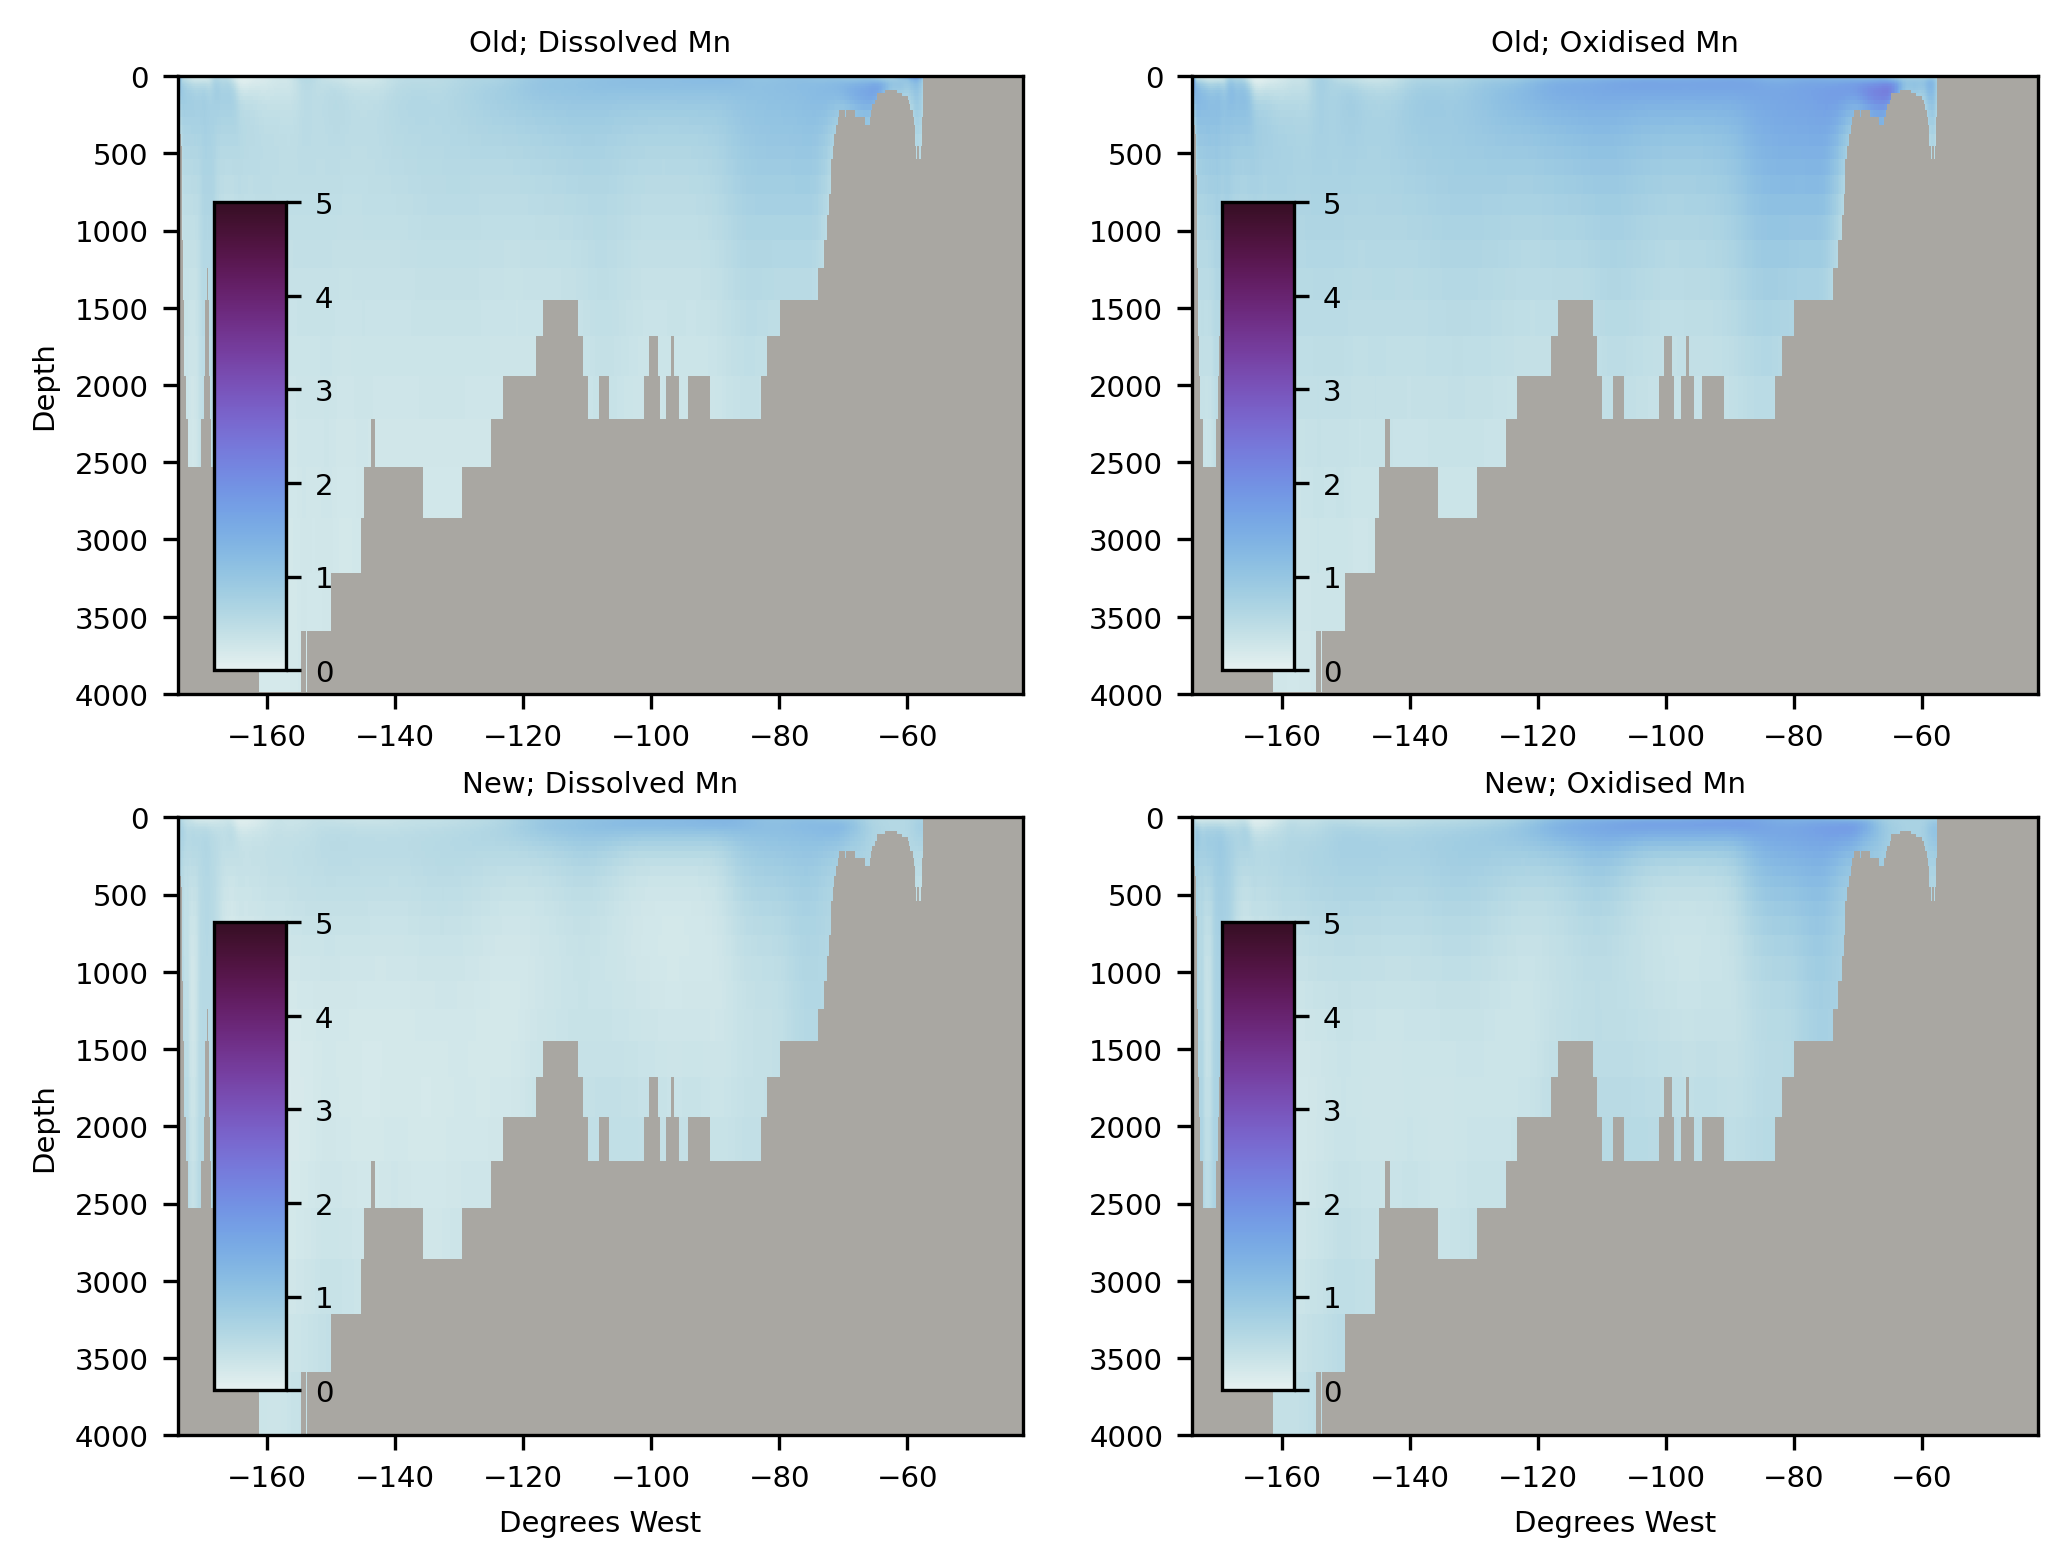

In [175]:
plot_boundary_transect_E(E_coordinates, dMn_east_old, oMn_east_old, dMn_east_new, oMn_east_new, 1, ylim=(4000,0))

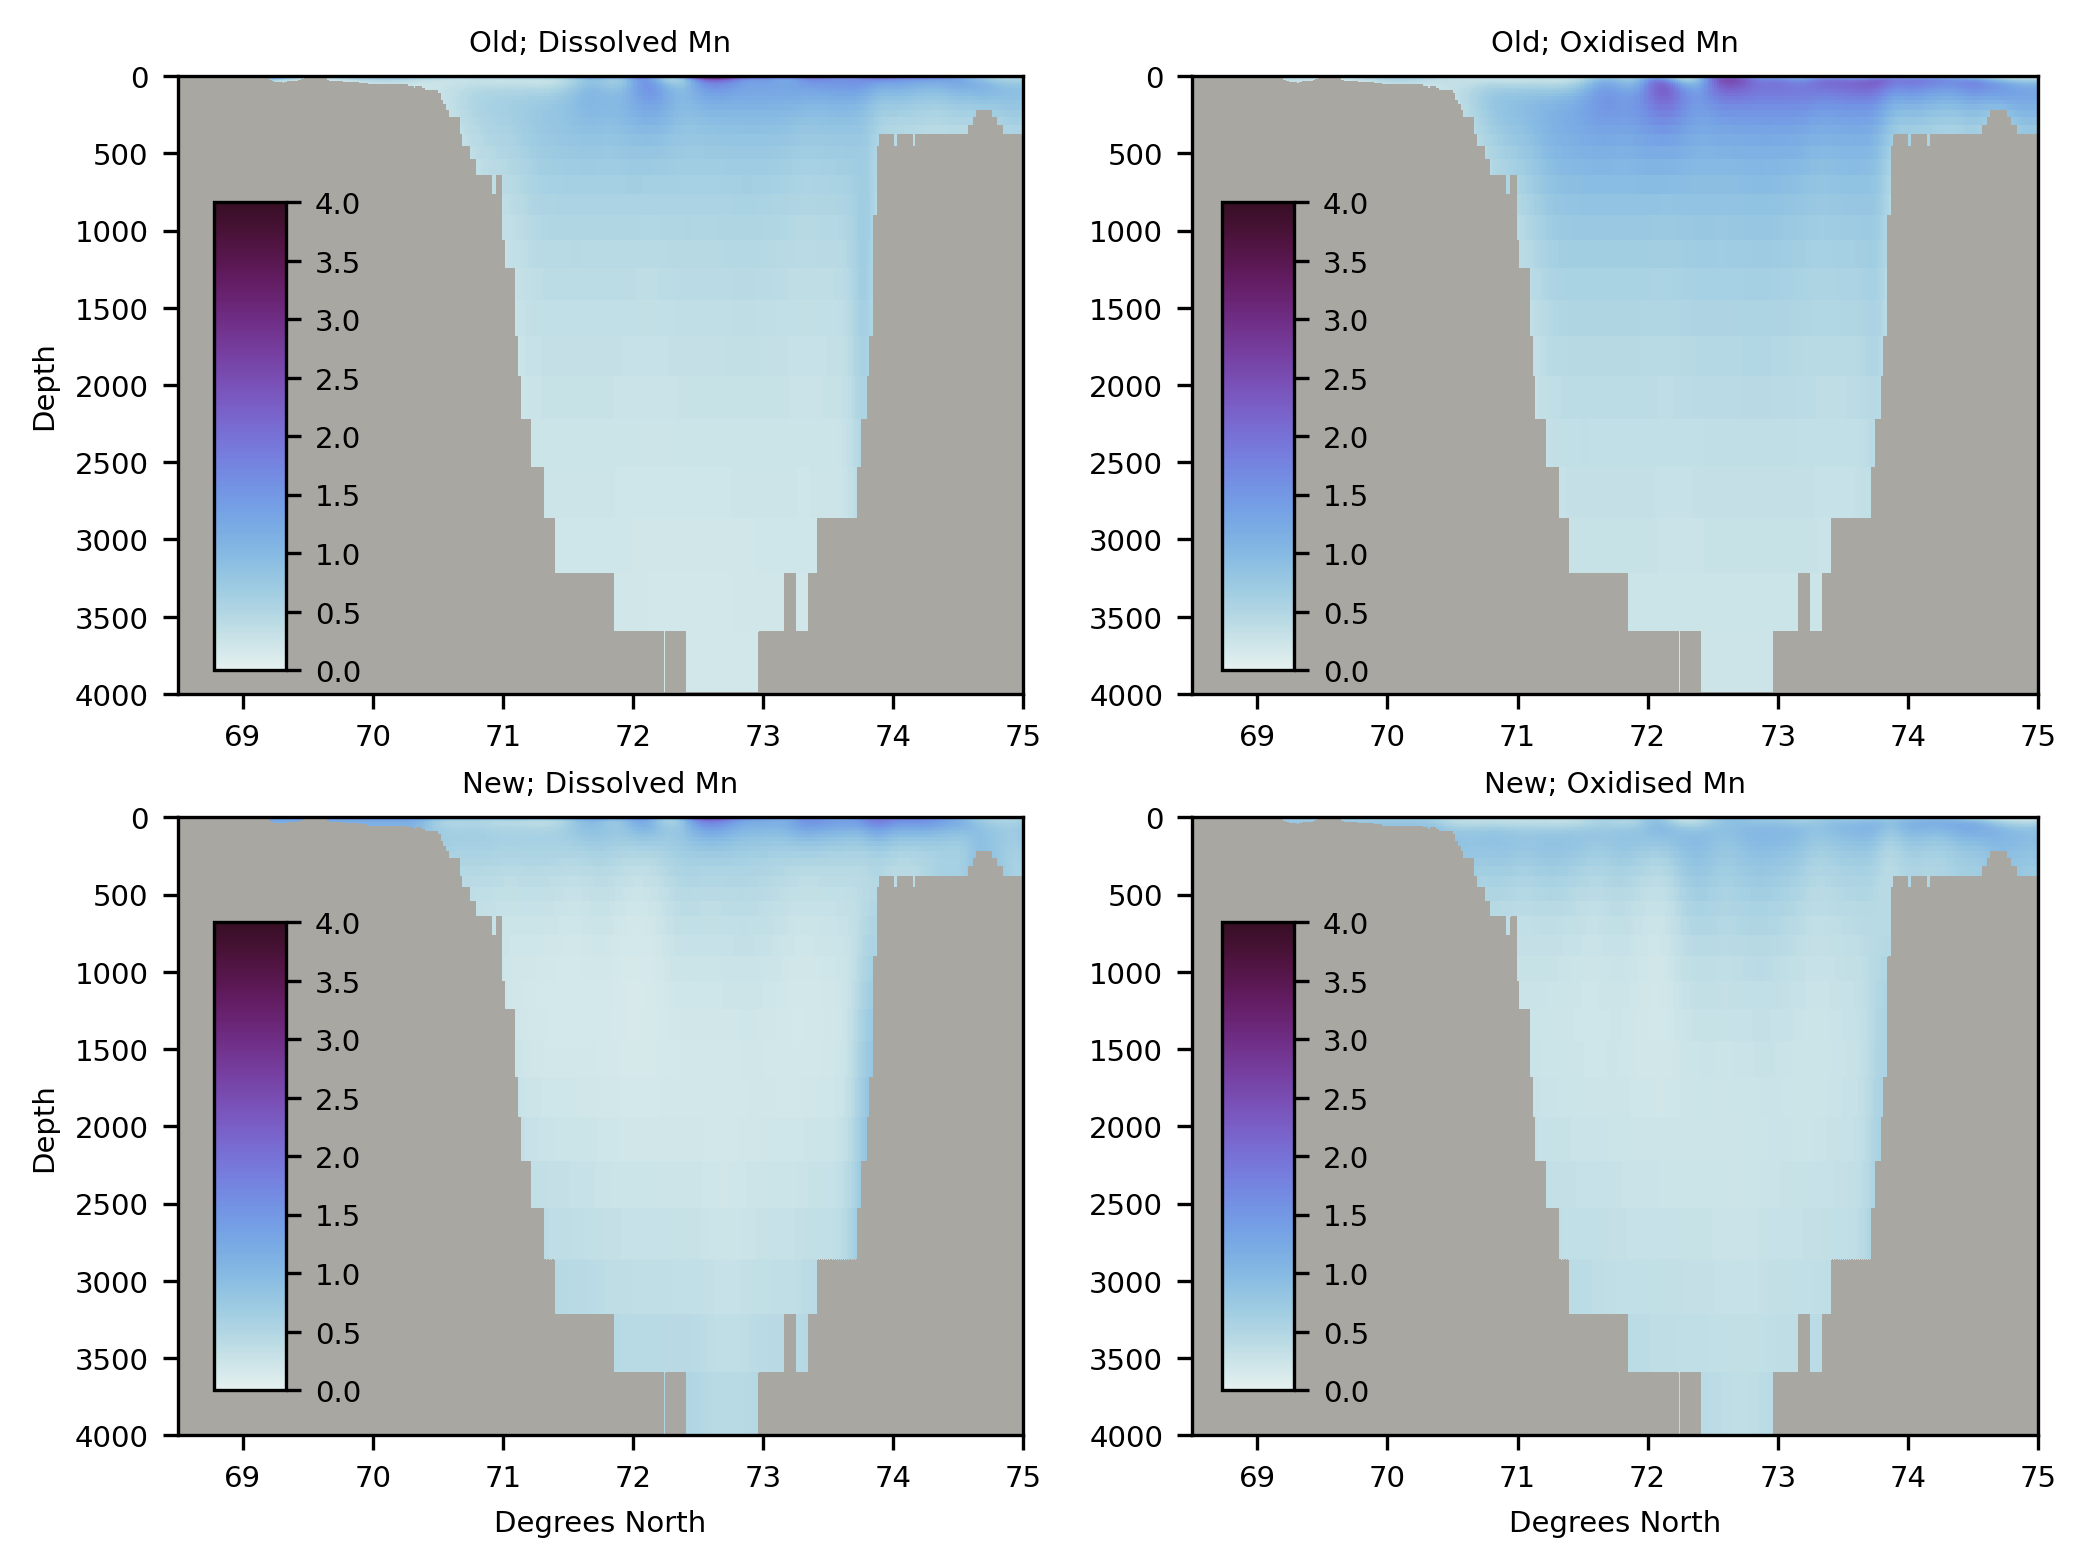

In [160]:
plot_boundary_transect_N(N_coordinates, dMn_north_old, oMn_north_old, dMn_north, oMn_north, 1, ylim=(4000,0))

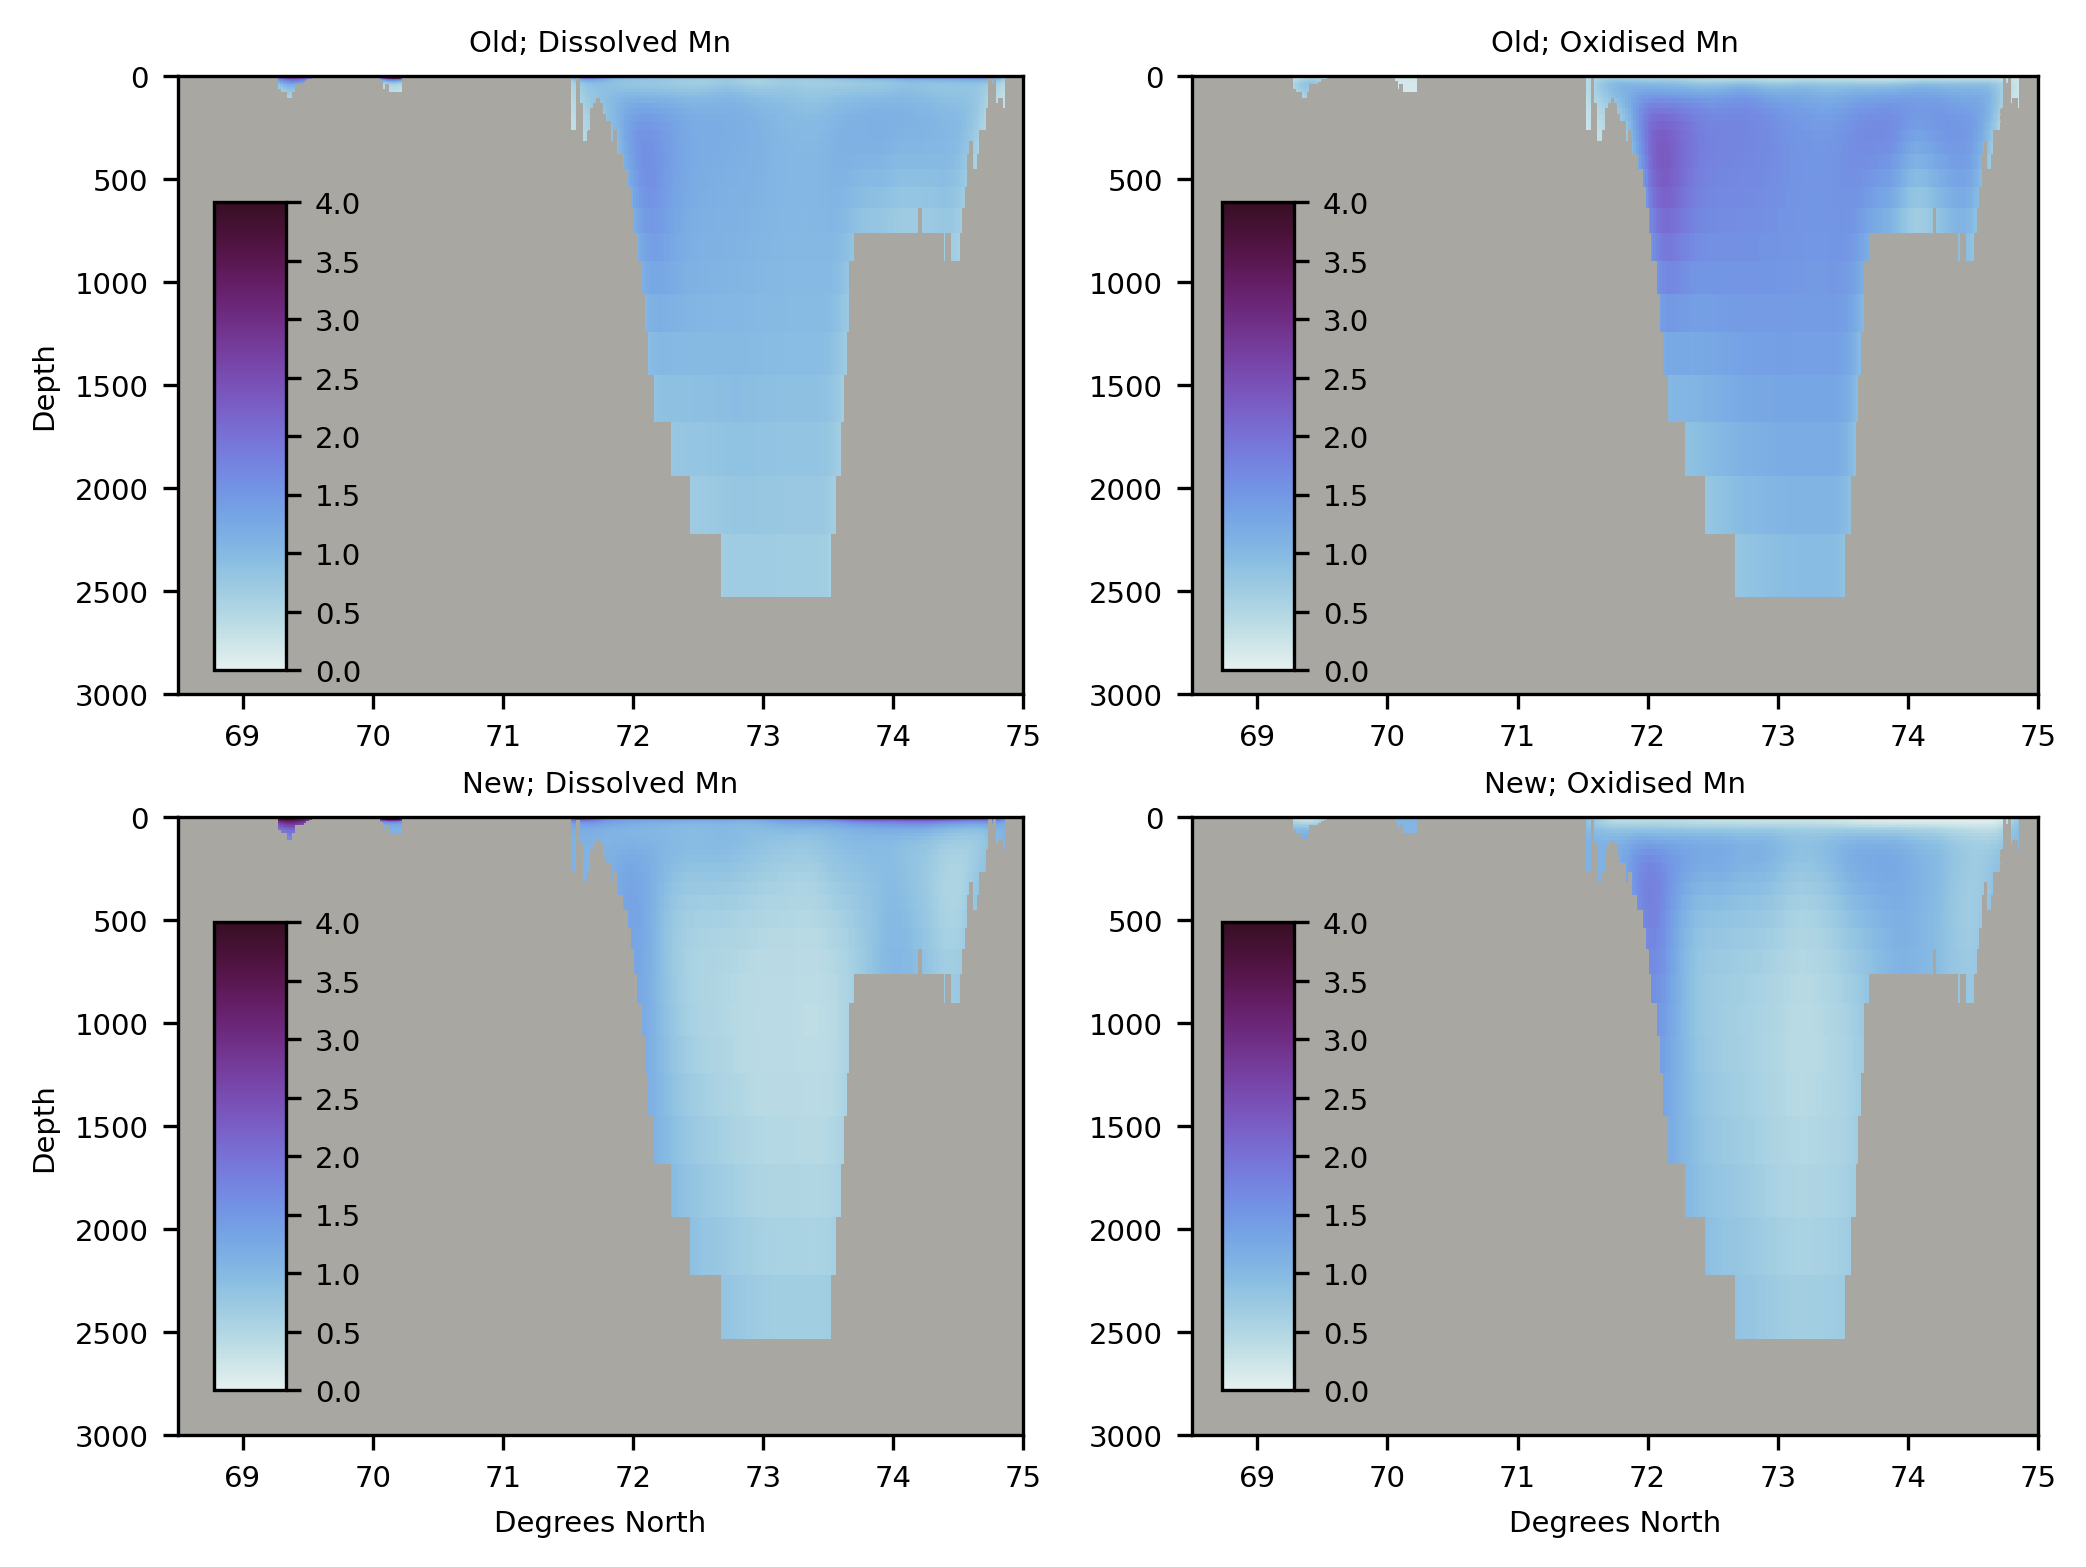

In [161]:
plot_boundary_transect_N(S_coordinates, dMn_south_old, oMn_south_old, dMn_south, oMn_south, 1, ylim=(3000,0))

In [162]:
def plot_BC(vmax1=4, vmax2=2, z_level=0, spec='dMn'):
    if spec=='dMn':
        Mn_north_old = dMn_north_old; Mn_east_old  = dMn_east_old; Mn_south_old = dMn_south_old;
        Mn_north     = dMn_north;     Mn_east      = dMn_east;     Mn_south     = dMn_south;
    else:
        Mn_north_old = oMn_north_old; Mn_east_old  = oMn_east_old; Mn_south_old = oMn_south_old;
        Mn_north     = oMn_north;     Mn_east      = oMn_east;     Mn_south     = oMn_south;
        
    fig, ax1, ax2, ax3, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/diff-panels.pickle','rb'))

    # Plot model background field:
    ax1.set_title('Old BC', fontsize=7)
    ax2.set_title('New BC', fontsize=7)
    ax3.set_title('Difference', fontsize=7)

    xN, yN = proj(mesh_lon[N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]], \
                  mesh_lat[N_coordinates[0]:N_coordinates[1],N_coordinates[2]:N_coordinates[3]])
    xE, yE = proj(mesh_lon[E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]], \
                  mesh_lat[E_coordinates[0]:E_coordinates[1],E_coordinates[2]:E_coordinates[3]])
    xS, yS = proj(mesh_lon[S_coordinates[0]:S_coordinates[1],S_coordinates[2]:S_coordinates[3]], \
                  mesh_lat[S_coordinates[0]:S_coordinates[1],S_coordinates[2]:S_coordinates[3]])
    CB1 = proj.pcolormesh(xN, yN, np.transpose(Mn_north_old[z_level,:,:]*10**9), vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, ax=ax1)
    proj.pcolormesh(xE, yE, Mn_east_old[z_level,:,:]*10**9 , vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, ax=ax1)
    proj.pcolormesh(xS, yS, np.transpose(Mn_south_old[z_level,:,:]*10**9), vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, ax=ax1)

    
    CB2 = proj.pcolormesh(xN, yN, Mn_north[z_level,:,:]*10**9, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, ax=ax2)
    proj.pcolormesh(xE, yE, Mn_east[z_level,:,:]*10**9 , vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, ax=ax2)
    proj.pcolormesh(xS, yS, Mn_south[z_level,:,:]*10**9, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, ax=ax2)

    CB3 = proj.pcolormesh(xN, yN, (Mn_north[z_level,:,:] - np.transpose(Mn_north_old[z_level,:,:]))*10**9, vmin=-vmax2, vmax=vmax2, cmap=cmocean.cm.balance, ax=ax3)
    proj.pcolormesh(xE, yE, (Mn_east[z_level,:,:] - Mn_east_old[z_level,:,:])*10**9 , vmin=-vmax2, vmax=vmax2, cmap=cmocean.cm.balance, ax=ax3)
    proj.pcolormesh(xS, yS, (Mn_south[z_level,:,:] - np.transpose(Mn_south_old[z_level,:,:]))*10**9, vmin=-vmax2, vmax=vmax2, cmap=cmocean.cm.balance, ax=ax3)


    for axis in [ax1, ax2, ax3]:
        # add bathymetry contours:
        x, y = proj(mesh_lon, mesh_lat)
        proj.contour(x, y, mesh_hdept, levels=[1000,2000,3000], linewidths=0.2, colors='k', zorder=3, ax=axis)
        proj.drawcoastlines(color='#373736', linewidth=1.0, ax=axis)

    cbar_ax1 = fig.add_axes([0.270, 0.663, 0.01, 0.09])
    cbar_ax2 = fig.add_axes([0.533, 0.663, 0.01, 0.09])
    cbar_ax3 = fig.add_axes([0.280, 0.15, 0.02, 0.16])

    # Colorbar:
    CBar1 = plt.colorbar(CB1, cax=cbar_ax1, ticks=np.arange(0, vmax1+2, 2))
    CBar2 = plt.colorbar(CB2, cax=cbar_ax2, ticks=np.arange(0, vmax1+2, 2))
    CBar3 = plt.colorbar(CB3, cax=cbar_ax3, ticks=np.arange(-vmax2-1, vmax2+1, 1))    

    for CBar in [CBar1, CBar2, CBar3]:
        CBar.ax.tick_params(labelsize=5) 
        CBar.set_label(f'{spec} [nM]', fontsize=5)

    CBar3.ax.tick_params(labelsize=7) 
    CBar3.set_label(f'{spec} change [nM]', fontsize=7)

    fig.text(0.27, 0.89, 'a)', fontsize=8);
    fig.text(0.532, 0.89, 'b)', fontsize=8);
    fig.text(0.27, 0.62, 'c)', fontsize=8);
    return

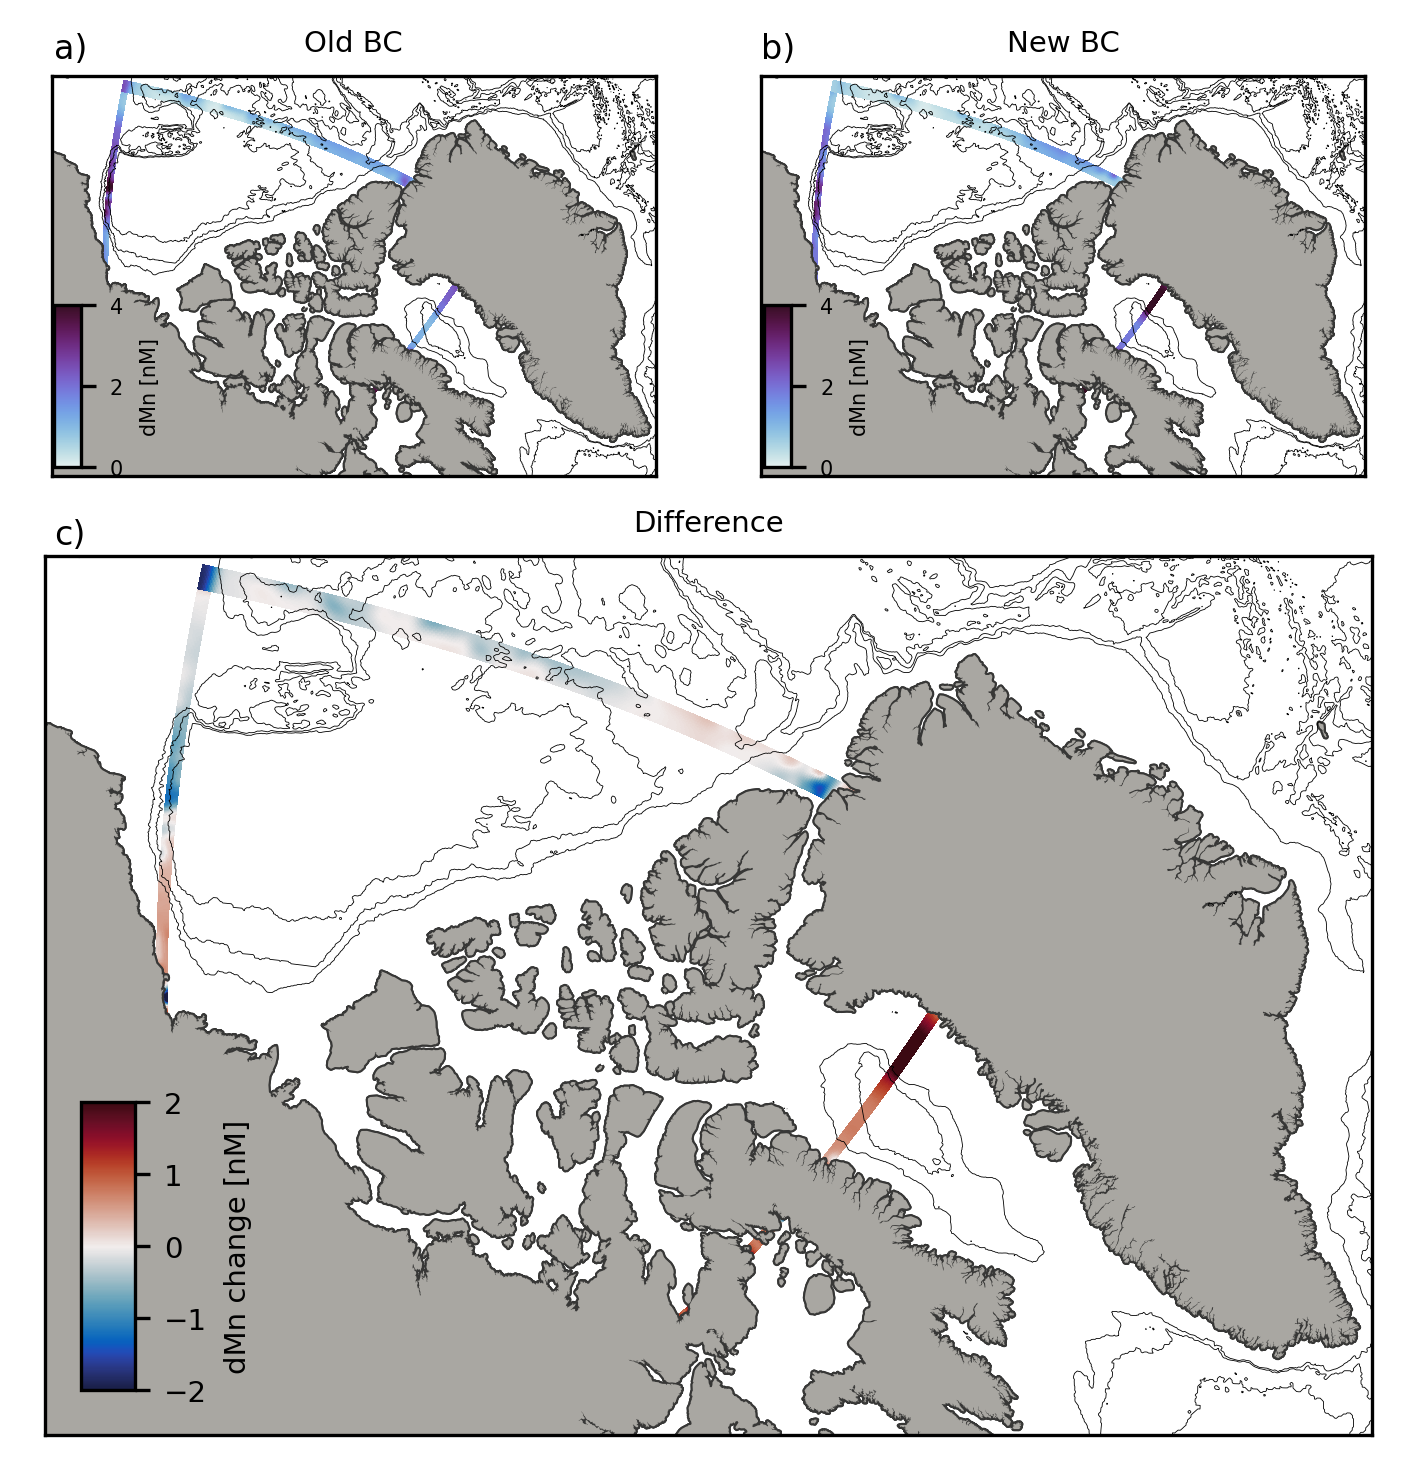

In [163]:
plot_BC(vmax1=4, vmax2=2, z_level=0, spec='dMn')

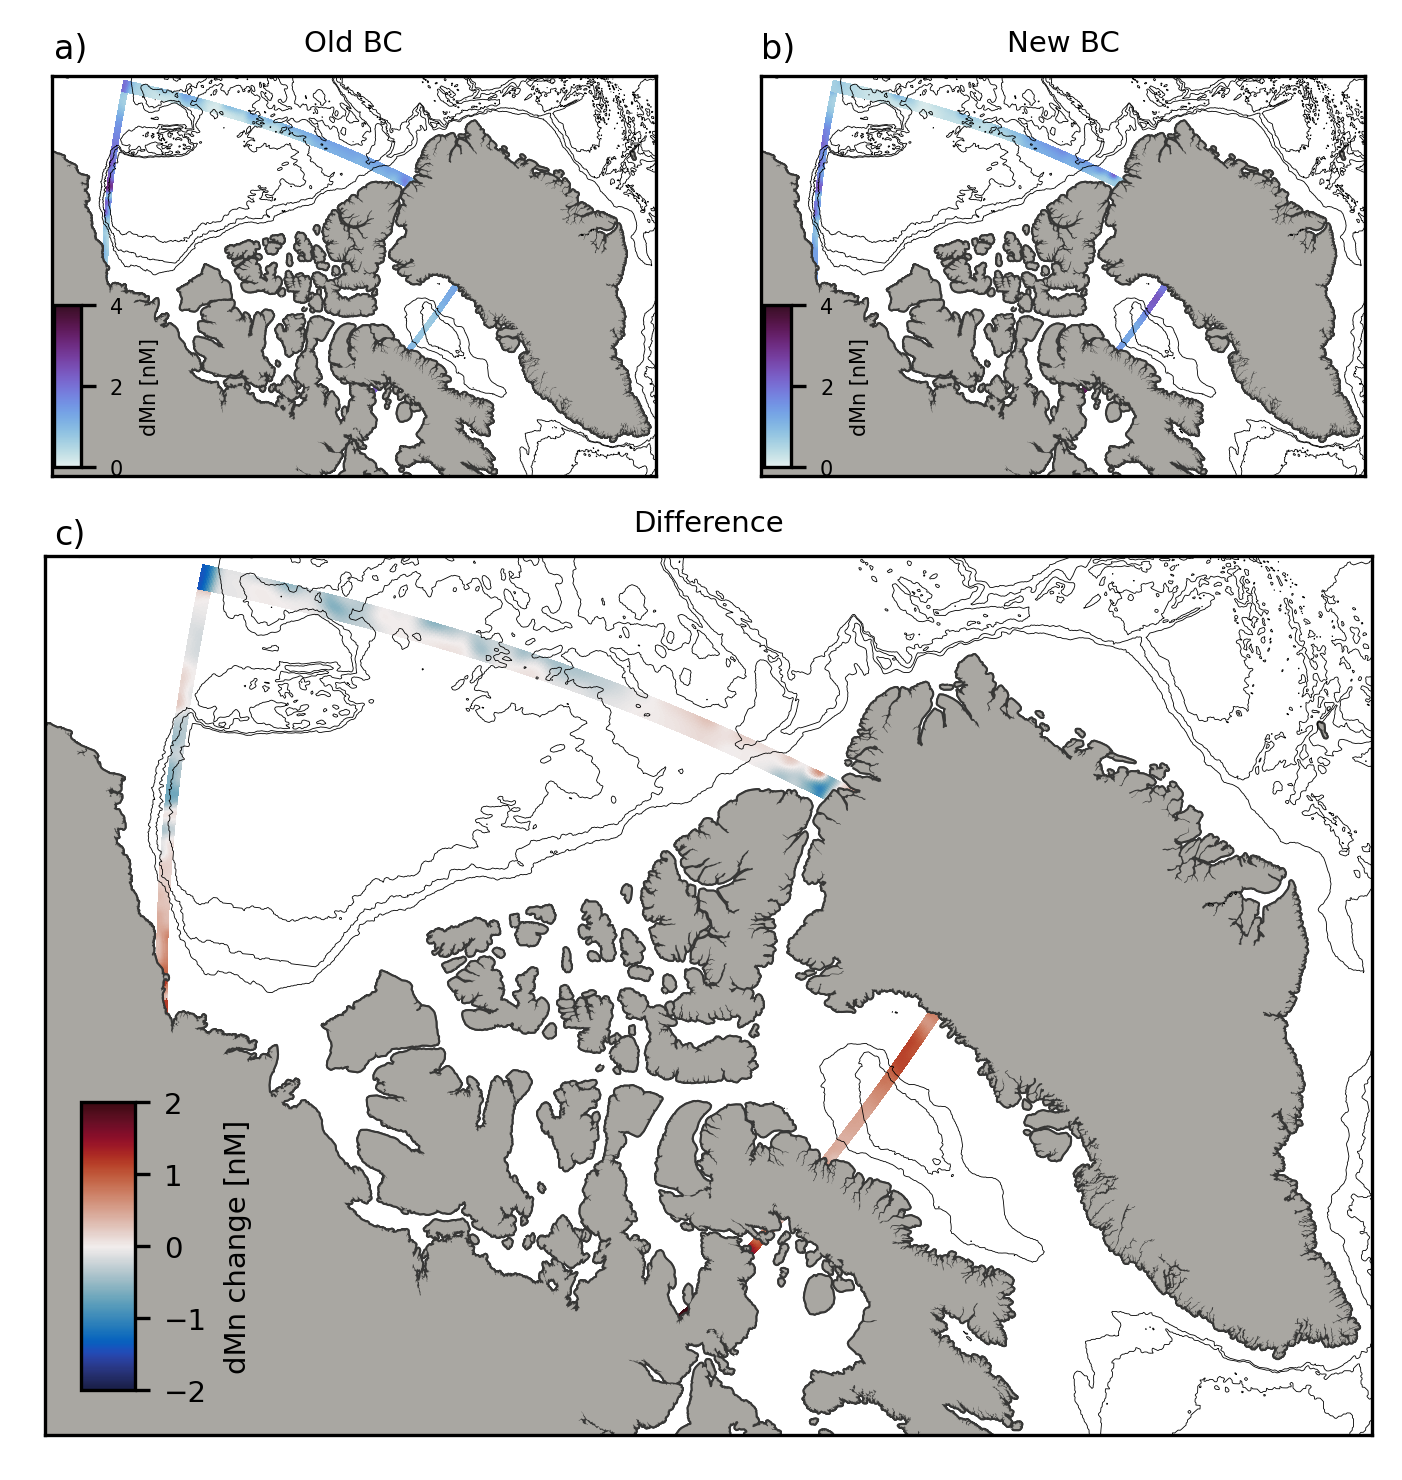

In [164]:
plot_BC(vmax1=4, vmax2=2, z_level=10, spec='dMn')

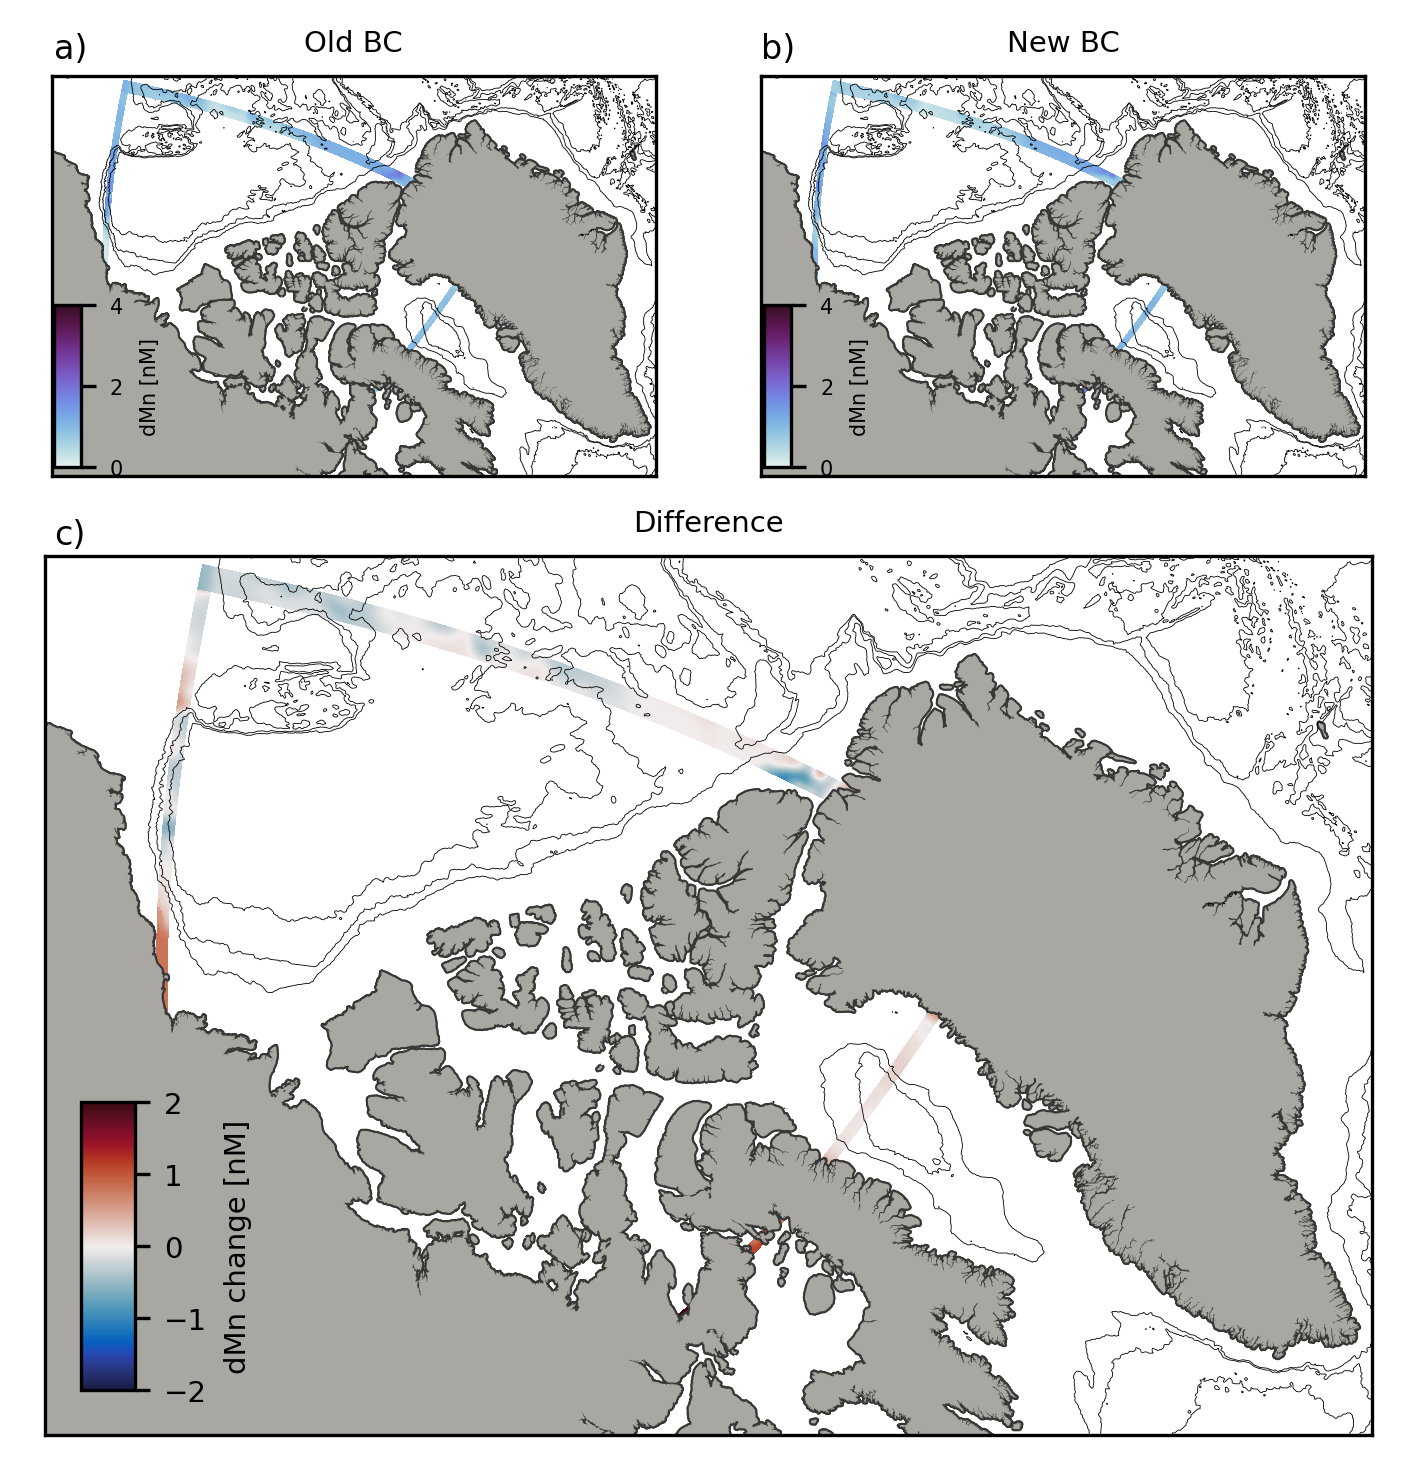

In [165]:
plot_BC(vmax1=4, vmax2=2, z_level=20, spec='dMn')

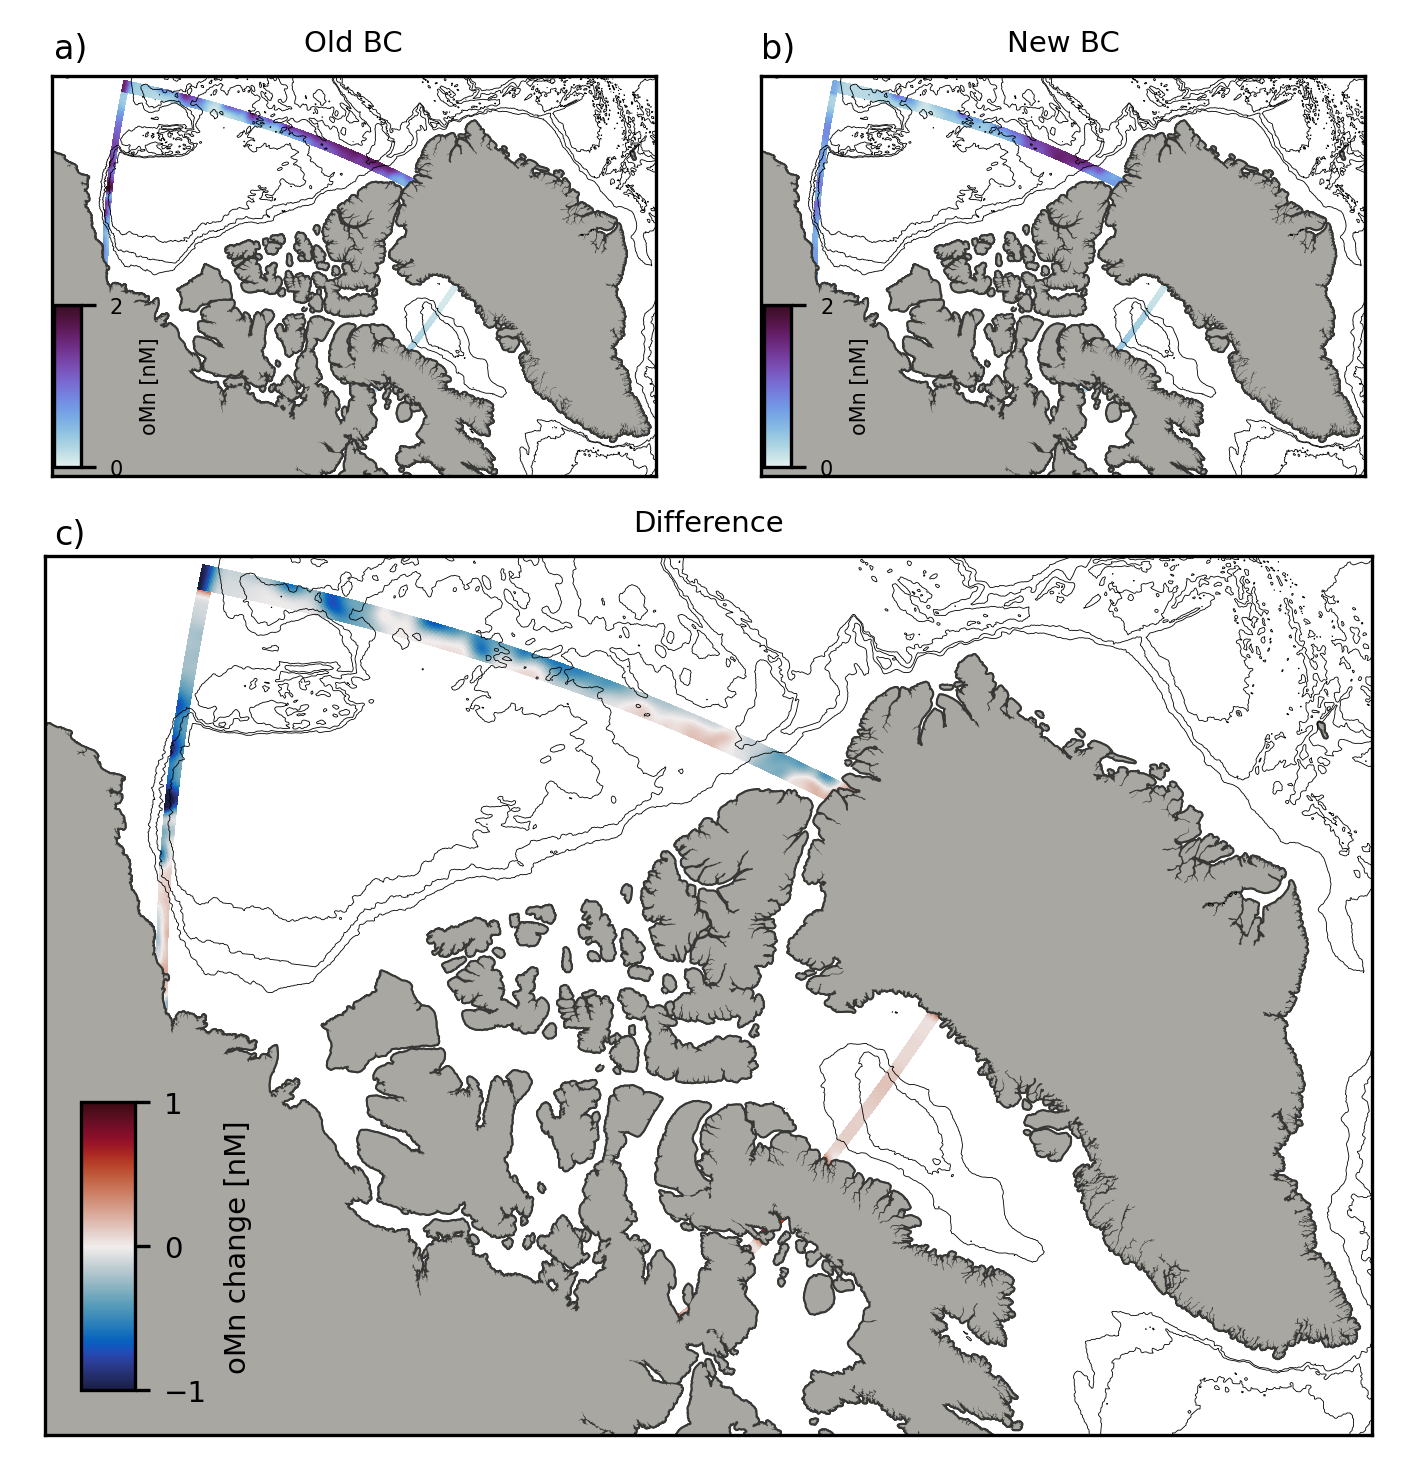

In [166]:
plot_BC(vmax1=2, vmax2=1, z_level=0, spec='oMn')

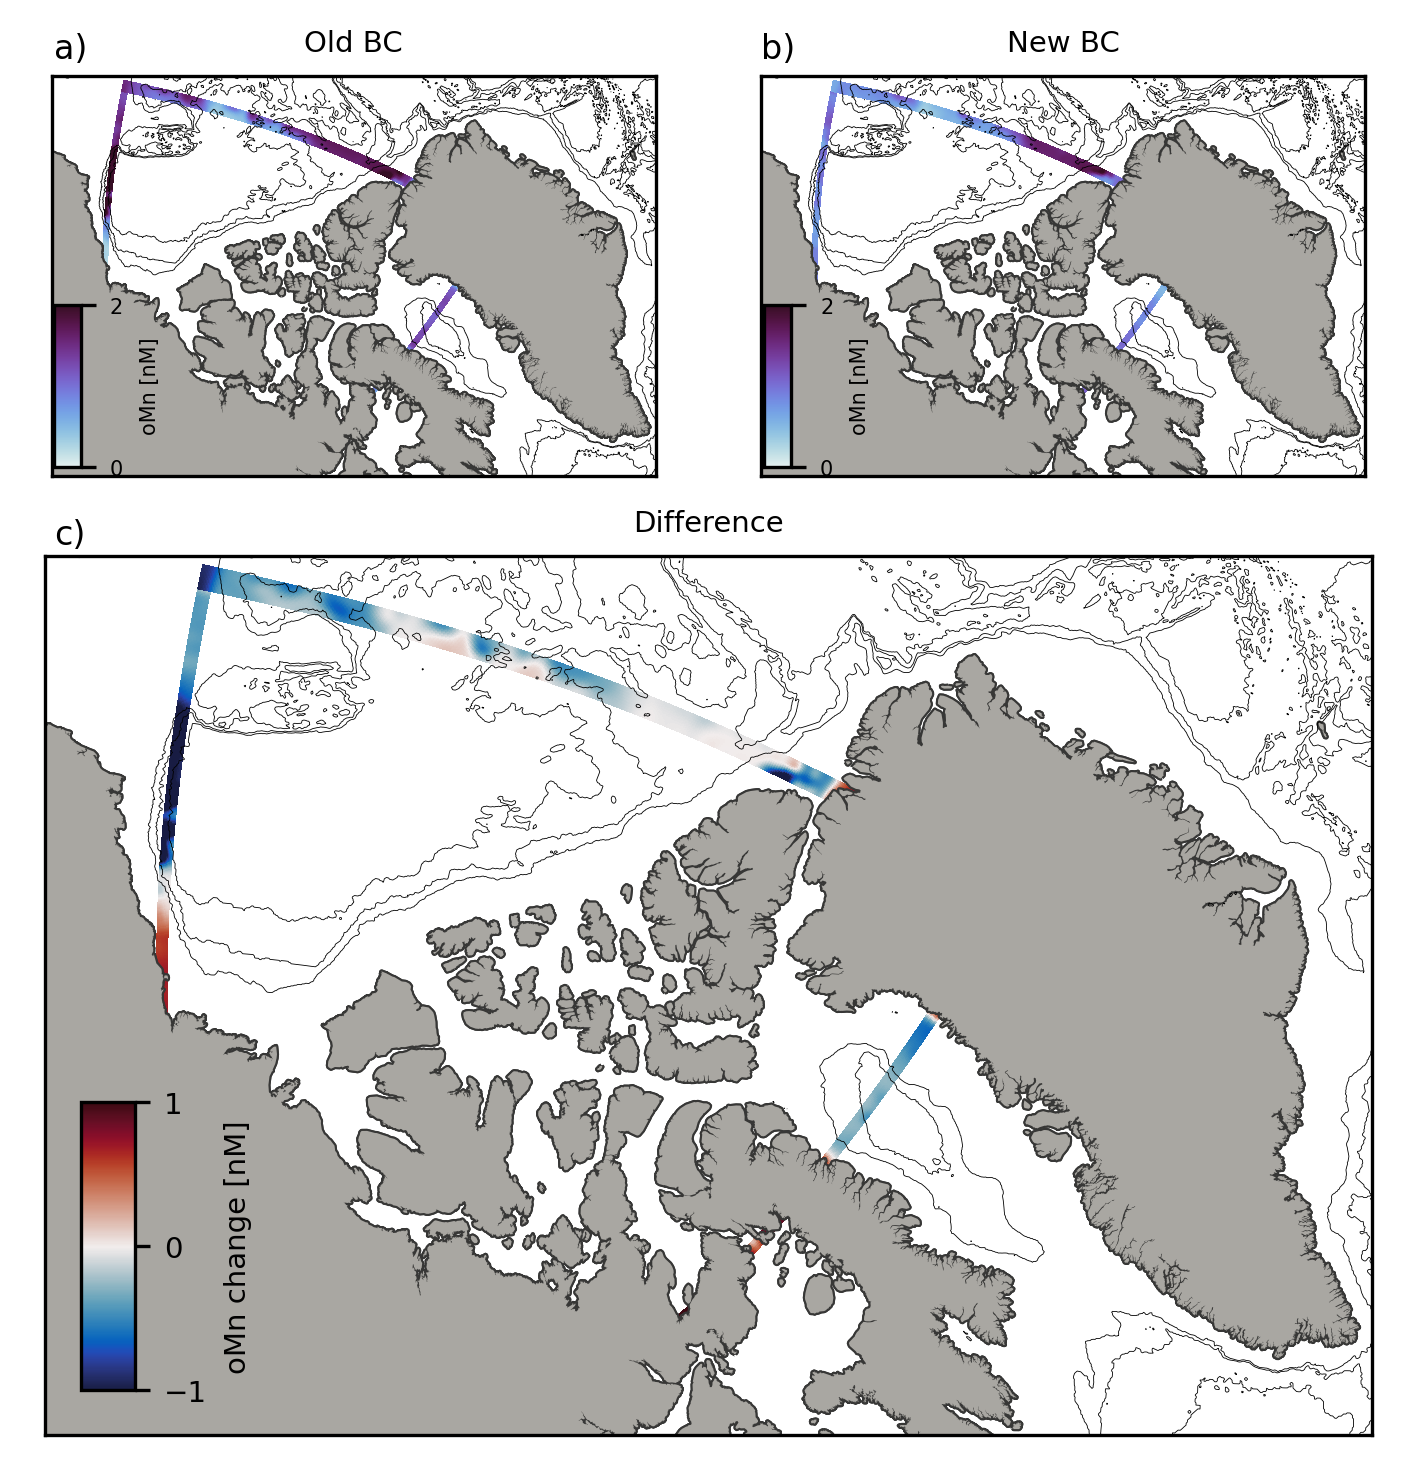

In [167]:
plot_BC(vmax1=2, vmax2=1, z_level=20, spec='oMn')